In [1]:
#Libraries
using Gen
using PyPlot 
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using Profile
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals_nodes.jl")
include("NUTS_CS.jl");

In [2]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"
#network = "interpolator"

#Data hyperparameters
n = 20 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
σₐ = 0.02 #Mode variance (classifier)
bound = 0.5

#Network hyperparameters

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]
k_real = 2

#NUTS
Δmax = 1000;

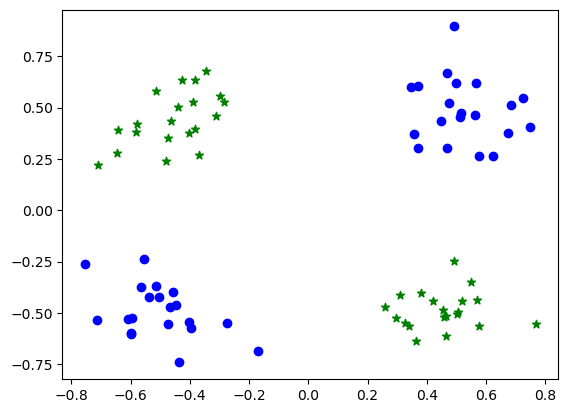

Transpose{Float64,Array{Float64,2}}

In [3]:
#Data
x_raw, classes = real_data_classifier(Int(N/4), 4, bound, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y_real = classes

plot_data_classifier(x_raw,classes)
x = transpose(x_raw)
size(x)
typeof(x)

In [4]:
#Bayesian Neural Net
function G(x, trace)
    activation = σ
    layers = 1 #trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function classifier(x)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l = 1
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ######################################
    #New hyperparameter schedule - Jan 20#
    ######################################
    
    #Standard Deviations
    τ₁ ~ gamma(100,0.001) #Hidden weights and biases
    τ₂ ~ gamma(100*k[1],0.001) #Output weights and biases
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    μ = [zeros(k[i]) for i=1:l+1]
    μb = [zeros(k[i]) for i=1:l+1]
   
     for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₁ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i]) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])    
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₁ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l]) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₂ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])  
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₂ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = scores
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end
    #y = [(@trace(categorical([1-scores[j],scores[j]]), (:y,j))) for j=1:length(scores)]

    return scores
end;
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;
(best_trace,) = generate(classifier, (x,), obs)

println(best_trace[:τ₁])
println(best_trace[:τ₂])

test_scores = classifier(x)
test_labels = data_labeller(test_scores)
test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

0.09708240182153531
0.712563462149731


40

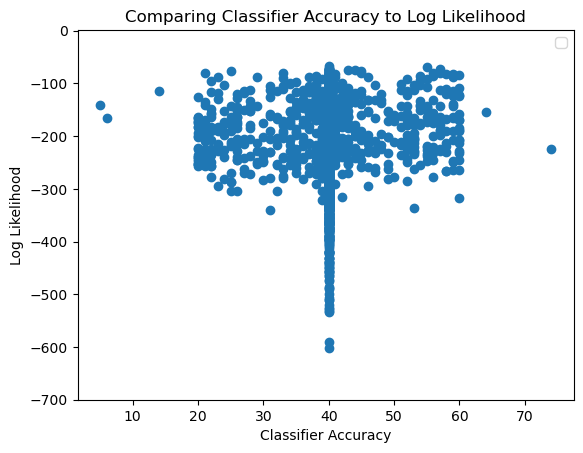

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7fae7bc1f7d0>

In [11]:
#----------------
#Test Likelihood
#----------------
scores = []
accs = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x,), obs)
best_acc = 0
best_score = get_score(best_trace)
best_pred_y = (G(x, best_trace))
best_pred_labels = data_labeller(best_pred_y)
best_k = best_trace[(:k,1)]
function likelihood(best_trace, best_acc, best_score, best_k)
    obs = obs_master;
    #obs[(:k,1)] = 2
    (trace,) = generate(classifier, (x,), obs)
    
    pred_y = (G(x, trace))
    pred_labels = data_labeller(pred_y)
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)

    if acc > best_acc
        best_acc = acc
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[(:k,1)]
    end
    push!(best_ks,best_k)
    push!(scores,score)
    push!(accs,acc)

    return(best_trace, best_acc, best_score, best_k)
end;

for i=1:2000
    best_trace, best_acc, best_score, best_k = likelihood(best_trace, best_acc, best_score, best_k)
    push!(best_ks, best_k)
end

PyPlot.scatter(accs, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.ylim(-700,1)
plt.legend()
#print(best_ks)

In [56]:
###############
#NUTS SAMPLING#
###############

include("NUTS_CS.jl")
Δ_max = 10
#Random.seed!(4)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []
hyper1_acceptance = []
hyper2_acceptance = []

#NUTS Hyperparameters
iters = 1
m = 1

function propose_hyperparameters(trace)
    
    hyper_selection = select()
    push!(hyper_selection, :τ₁)
    push!(hyper_selection, :τ₂)
    (new_trace, weight, retdiff) = regenerate(trace, hyper_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
end;

function hmc_parameters(trace)
    
    param_selection = select()
    for i=1:1+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:iters
        trace = NUTS(trace, param_selection, 0.55, m, m, false)[m+1]
        new_score = get_score(trace)
        if prev_score != new_score
            acc = 1
        end
    end
    
    return (trace, acc)
end

function hmc_hyperparameters2(trace)
    
    hyper2_selection = select()
    for i=1:1+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    prev_score = get_score(trace)
    trace = NUTS(trace, hyper2_selection, 0.65, m, m, false)[m+1]
    new_score = get_score(trace)
    
    (new_trace, weight, retdiff) = regenerate(trace, hyper2_selection)
    
    #if log(rand()) < weight
    #    return (new_trace, 1)
    #else
    #    return (trace, 0)
    #end
    
    if prev_score != new_score
        return (trace, 1)
    else
        return (trace, 0)
    end
    
end

function node_parameter(trace)
    obs = obs_master
    
    init_trace = trace
    
    #################################################RJHMC#################################################
    #HMC Step 1
    trace_tilde = trace
    for i=1:iters
        (trace_tilde,) = propose_hyperparameters(trace_tilde)
        (trace_tilde,) = hmc_hyperparameters2(trace_tilde)
        (trace_tilde,) = hmc_parameters(trace_tilde)
        #(trace_tilde, accepted) = hmc(trace_tilde,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
    end
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    #HMC Step 2
    trace_star = trace_prime
    for i=1:iters
        #(trace_star, accepted) = hmc(trace_star,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        (trace_star,) = hmc_parameters(trace_star)
        (trace_star,) = hmc_hyperparameters2(trace_star)
        (trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJHMC#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[(:k,1)]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

(trace,) = generate(classifier, (x,), obs)
trace = best_trace

for i=1:2000
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    (trace, accepted)  = propose_hyperparameters(trace)
    push!(hyper1_acceptance, accepted)
    (trace, accepted)  = hmc_hyperparameters2(trace)
    push!(hyper2_acceptance, accepted)
    (trace, accepted)  = hmc_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    push!(ks, trace[(:k,1)])
    println("$i : $(get_score(trace))")
    if i%20 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

1 : -222.36117169349143
********** Accepted: 11 **********
2 : -196.46559257559696
3 : -201.02365852605297
4 : -199.57833611074895
********** Accepted: 10 **********
5 : -171.70099311536
6 : -170.49720066533996
7 : -168.68198698347808
8 : -171.32357040941284
9 : -170.32737100027705
10 : -170.16730817814732
11 : -170.09141328093577
12 : -175.11470049144847
13 : -177.13323442227275
14 : -175.73702505071714
15 : -176.37752469513086
16 : -175.23349209703196
17 : -176.6989480804741
18 : -173.19693673437015
19 : -173.04271241507644
20 : -172.81924347091035
Epoch 20 A Acceptance Probability: 10.0 %
Epoch 20 W Acceptance Probability: 85.0 %
21 : -172.81924347091035
22 : -174.66538812276923
23 : -175.29078464861956
24 : -180.72323640095675
25 : -179.7730653246869
26 : -181.55202132331013
27 : -182.5784848429441
28 : -182.86983207215889
29 : -185.05462358993222
30 : -186.7859820655623
********** Accepted: 11 **********
31 : -207.4924453786509
********** Accepted: 10 **********
32 : -188.68128961

251 : -79.94870434534961
252 : -81.55251015652978
253 : -83.71879980202874
254 : -81.3761501497807
255 : -82.00648940209078
********** Accepted: 5 **********
256 : -98.4111365188608
********** Accepted: 4 **********
257 : -83.09857693703339
258 : -84.09855511087304
259 : -82.15171563128611
260 : -81.99558074992858
Epoch 260 A Acceptance Probability: 9.230769230769232 %
Epoch 260 W Acceptance Probability: 75.38461538461539 %
261 : -83.28275684809377
262 : -83.71313809335349
263 : -81.24056818091255
264 : -81.66369016651323
265 : -81.99093642853234
266 : -87.64475686115645
267 : -88.59383592517165
268 : -88.59383592517165
269 : -90.95935750388053
270 : -90.78482976769568
271 : -92.91546910736184
272 : -90.58531444972587
********** Accepted: 3 **********
273 : -69.33096372101053
274 : -71.43392177427391
275 : -72.37741359503785
276 : -72.94888168111987
277 : -76.35917201725465
278 : -76.49198806778483
279 : -74.90422512476049
280 : -72.20267007394546
Epoch 280 A Acceptance Probability: 8.

514 : -74.35812802753118
515 : -76.0890718364647
516 : -77.89244307648214
517 : -75.6385669057593
518 : -73.37755685508102
519 : -72.84690931999465
520 : -74.30840684850267
Epoch 520 A Acceptance Probability: 5.5769230769230775 %
Epoch 520 W Acceptance Probability: 74.42307692307692 %
521 : -75.88970457679395
522 : -71.23140179176187
523 : -71.31754341003428
524 : -71.22109151789599
525 : -71.9147079241673
526 : -71.87609926150732
527 : -78.0569187952264
528 : -73.00607911467579
529 : -72.41230201206957
530 : -71.7371657331795
531 : -69.79849978986617
532 : -70.40291072768356
533 : -71.17142300812117
534 : -72.59616275034026
535 : -71.82888800701912
536 : -71.39118576439515
537 : -70.71091545512945
538 : -74.655343552734
539 : -73.6276479779839
540 : -72.26736512070227
Epoch 540 A Acceptance Probability: 5.37037037037037 %
Epoch 540 W Acceptance Probability: 74.62962962962963 %
541 : -73.08102822674928
542 : -73.1861585190295
543 : -73.10807105490295
544 : -74.80952838435373
545 : -78.

776 : -68.32053726119017
777 : -66.56304423914867
778 : -67.27561388120442
779 : -67.11551922196892
780 : -69.60164739437303
Epoch 780 A Acceptance Probability: 4.743589743589744 %
Epoch 780 W Acceptance Probability: 74.23076923076923 %
781 : -68.63473940872157
782 : -67.47630799039443
783 : -72.8996723576892
784 : -72.67526958981234
785 : -71.27985717720055
786 : -70.86667795015533
787 : -70.73852868904925
788 : -71.39442340271366
789 : -71.5941052251488
790 : -73.29818185687775
791 : -70.84316085740436
792 : -69.92583640468348
793 : -70.16097242747674
794 : -71.1576413750296
795 : -67.54531366282302
796 : -67.96918676699006
797 : -68.25873208113852
798 : -69.88006668059832
799 : -71.96643028480078
800 : -73.23662616419566
Epoch 800 A Acceptance Probability: 4.625 %
Epoch 800 W Acceptance Probability: 74.375 %
801 : -73.21748182500204
802 : -72.3797732544418
803 : -66.98862261039062
804 : -69.30025035708076
805 : -69.24184554095112
806 : -72.07078674542382
807 : -68.61826828668512
808

1041 : -69.44364748008122
1042 : -70.66597503752432
1043 : -71.2264615657734
1044 : -70.58850075521563
1045 : -74.5340675200523
1046 : -72.19583848612098
1047 : -74.03468738133107
1048 : -73.67957877327675
1049 : -70.0378110856776
1050 : -72.98596729713984
1051 : -73.52446229619086
1052 : -72.87103490087658
1053 : -74.03656793324215
1054 : -73.30928132711031
1055 : -73.30070916783325
1056 : -74.53638821756846
1057 : -73.94853445038235
1058 : -71.23813569226279
1059 : -69.8894791974737
1060 : -70.47794955744362
Epoch 1060 A Acceptance Probability: 3.8679245283018866 %
Epoch 1060 W Acceptance Probability: 74.62264150943396 %
1061 : -76.22888978827135
1062 : -74.28584288481477
1063 : -72.10142450786745
1064 : -70.11681497234828
1065 : -71.39692917255213
1066 : -72.80110570900116
1067 : -71.78059044742665
1068 : -68.459480213905
1069 : -68.5340711516429
1070 : -67.9130981599279
Go
1071 : -70.40138554504098
1072 : -69.1688129419163
1073 : -68.39769456797067
1074 : -67.31697290542635
1075 : 

1299 : -91.4114833096765
1300 : -91.57844931502154
Epoch 1300 A Acceptance Probability: 3.5384615384615383 %
Epoch 1300 W Acceptance Probability: 74.07692307692308 %
1301 : -92.78848304980752
1302 : -93.08980886941497
1303 : -90.86569611593892
1304 : -91.95817858808792
1305 : -93.7940989306839
********** Accepted: 3 **********
1306 : -73.1471279889026
1307 : -76.87015685875126
1308 : -70.09285001394149
1309 : -70.08245343524031
1310 : -74.75855780205569
1311 : -72.33833890930485
1312 : -74.57434818052232
1313 : -74.43304156355676
1314 : -70.70251220568676
1315 : -73.66251343551245
1316 : -74.21509592871809
1317 : -75.29964210288009
1318 : -76.5004089539643
1319 : -79.71205849338087
1320 : -72.52382361705227
Epoch 1320 A Acceptance Probability: 3.5606060606060606 %
Epoch 1320 W Acceptance Probability: 74.16666666666667 %
1321 : -74.91105217141744
1322 : -75.01318196974674
1323 : -74.12589498731433
1324 : -74.32359546141771
1325 : -79.60119593141711
1326 : -79.95635330556681
1327 : -81.7

1555 : -71.70250862268304
1556 : -73.49846977865852
1557 : -73.53922992633902
1558 : -73.13076957908454
1559 : -76.65160701765669
1560 : -76.65160701765669
Epoch 1560 A Acceptance Probability: 3.141025641025641 %
Epoch 1560 W Acceptance Probability: 73.91025641025641 %
1561 : -76.45153242040081
1562 : -78.63113142822327
1563 : -78.44394222492143
1564 : -76.61816811407888
1565 : -77.69322660374472
1566 : -75.79058039578348
1567 : -74.0267161099478
1568 : -77.74187283921974
1569 : -74.93479331914473
1570 : -74.93479331914473
1571 : -69.65398742958492
1572 : -68.01509434902829
1573 : -73.3739603731711
1574 : -66.3926127562244
1575 : -67.51887717593277
1576 : -68.11150386688064
1577 : -67.39966202528758
1578 : -75.51977650327704
1579 : -74.9900776210396
1580 : -75.64256870539856
Epoch 1580 A Acceptance Probability: 3.10126582278481 %
Epoch 1580 W Acceptance Probability: 73.73417721518987 %
1581 : -75.97461879022654
1582 : -74.60099425197524
1583 : -75.33254472666025
1584 : -74.319097384757

1813 : -73.55918160775158
1814 : -72.79309443575279
1815 : -72.02146144603483
1816 : -71.40211091571817
1817 : -72.97939319843292
1818 : -73.38933414813472
1819 : -70.75469725151281
1820 : -72.82776977570578
Epoch 1820 A Acceptance Probability: 2.8021978021978025 %
Epoch 1820 W Acceptance Probability: 73.18681318681318 %
1821 : -75.58141644701624
1822 : -70.8862981712633
1823 : -70.20916279326624
1824 : -70.20916279326624
1825 : -74.2857369225101
1826 : -71.25720512335792
1827 : -68.40433105197344
1828 : -73.26847831519007
1829 : -71.94193719058964
1830 : -71.42625519775045
1831 : -72.59256788314518
1832 : -72.73337348758906
1833 : -72.43799734631978
1834 : -72.27992475470894
1835 : -72.27992475470894
1836 : -72.27992475470894
1837 : -73.16834186641671
1838 : -73.3348455985975
1839 : -74.01754418404876
1840 : -71.15199942319903
Epoch 1840 A Acceptance Probability: 2.7717391304347827 %
Epoch 1840 W Acceptance Probability: 73.20652173913044 %
1841 : -67.75342242392435
1842 : -64.86063958

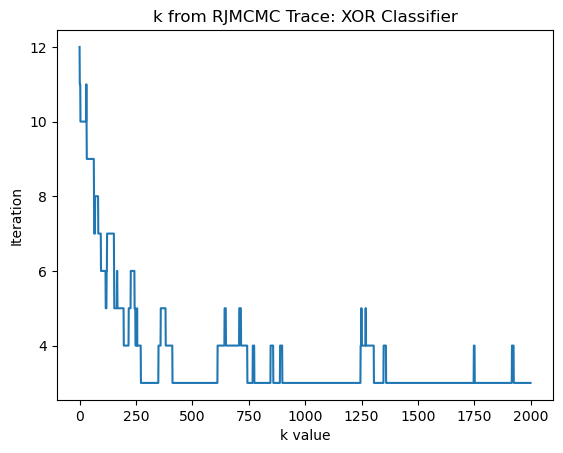

In [68]:
#-------
#K Plot
#-------
plot(ks)

plt.title("k from RJMCMC Trace: XOR Classifier")
plt.xlabel("k value")
plt.ylabel("Iteration");

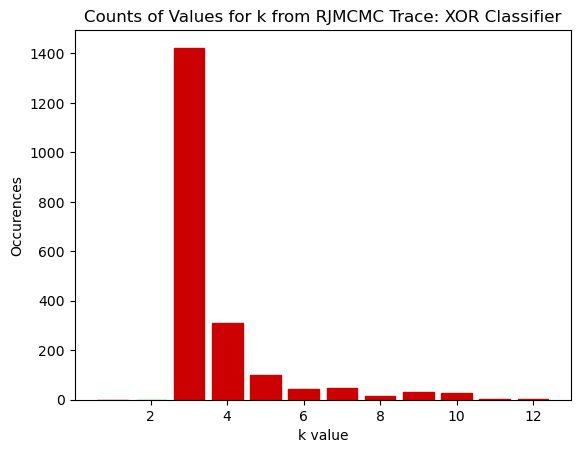

In [64]:
#Bar Plot of k estimates
ks = [traces[i][(:k,1)] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace: XOR Classifier")
plt.xlabel("k value")
plt.ylabel("Occurences");

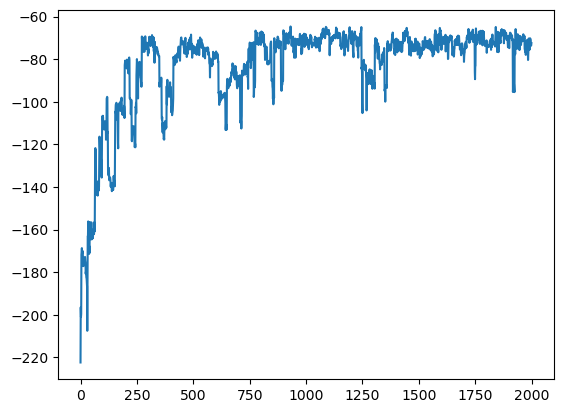

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fae692f6090>

In [58]:
#-----------
#Score plot
#-----------

scores = [get_score(trace) for trace in traces]
plot(scores)
#plt.ylim(-200,0)

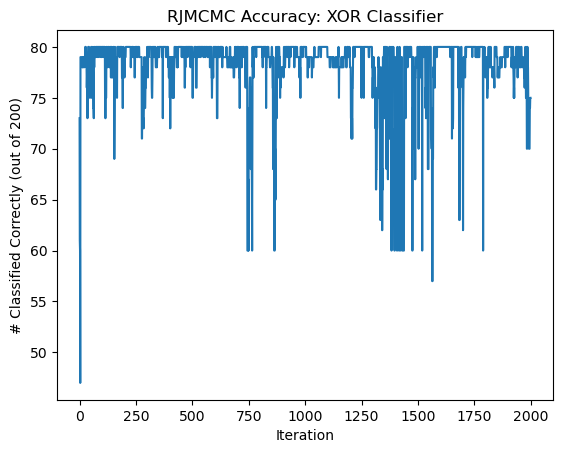

78.198


In [59]:
#---------------
#Accuracy plot
#---------------

accs = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = G(x,trace)
    pred_labels = data_labeller(pred_y)
    
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    push!(accs,acc)
end

plot(accs)
println(sum(accs)/length(accs))
plt.title("RJMCMC Accuracy: XOR Classifier")
plt.xlabel("Iteration")
plt.ylabel("# Classified Correctly (out of 200)");

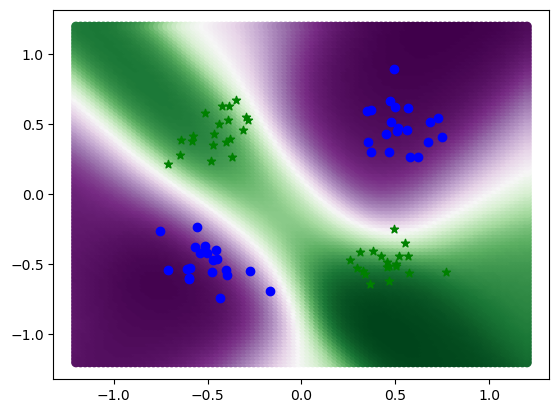

In [67]:
#---------------
#Classifier plot
#---------------

function plot_grid(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha,cmap="PRGn")
    #PyPlot.colorbar()
end

function tracegrid(traces, samples=2000, low=-1.2, high=1.2)
    d=2
    n=100
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z_master = zeros(length(grid2[1,:]))
    
    for i=1:samples
        j = rand((20,length(traces)))
        trace = traces[j]
        z = Flux.σ.(G(grid2,trace))[1,:]
        z_master += (z ./ samples)
    end
    plot_grid(grid_raw, z_master)
end

tracegrid(traces)
plot_data_classifier(x_raw,classes)

In [7]:
##############
#HMC SAMPLING#
##############
include("hmc_mod.jl")

Random.seed!(4)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []
hyper1_acceptance = []
hyper2_acceptance = []

#HMC Hyperparameters
leap = 100
ϵ = uniform(0.02,0.03)
iters = 1

function propose_hyperparameters(trace)
    
    hyper_selection = select()
    push!(hyper_selection, :τ₁)
    push!(hyper_selection, :τ₂)
    (new_trace, weight, retdiff) = regenerate(trace, hyper_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
end;

function hmc_parameters(trace)
    
    param_selection = select()
    for i=1:1+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    acc = 0
    for i=1:iters
        (trace, accepted) = hmc(trace,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        if accepted
            acc = 1
        end
    end
    
    if acc == 1
        return (trace, 1)
    else
        return (trace, 0)
    end
end

function hmc_hyperparameters2(trace)
    
    hyper2_selection = select()
    for i=1:1+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    (trace, accepted) = hmc(trace,hyper2_selection,L=leap,eps=ϵ,check=false,observations=obs)
    
    if accepted
        return (trace, 1)
    else
        return (trace, 0)
    end
    
end

function node_parameter(trace)
    obs = obs_master
    
    prev_trace = trace
    
    hyper1_selection = select()
    push!(hyper1_selection, :τ₁)
    push!(hyper1_selection, :τ₂)
    
    hyper2_selection = select()
    for i=1:1+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    param_selection = select()
    for i=1:1+1 #Number of Layers
        #push!(param_selection, (:μ,i))
        #push!(param_selection, (:μb,i))
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    #################################################RJHMC#################################################
    #HMC Step 1
    trace_tilde = trace
    for i=1:iters
        (trace_tilde,) = propose_hyperparameters(trace_tilde)
        (trace_tilde,) = hmc_hyperparameters2(trace_tilde)
        (trace_tilde,) = hmc_parameters(trace_tilde)
        #(trace_tilde, accepted) = hmc(trace_tilde,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
    end
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    #HMC Step 2
    trace_star = trace_prime
    for i=1:iters
        #(trace_star, accepted) = hmc(trace_star,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        (trace_star,) = hmc_parameters(trace_star)
        (trace_star,) = hmc_hyperparameters2(trace_star)
        (trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJHMC#################################################
        
    model_score = -get_score(prev_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("Accepted: $(trace_star[(:k,1)])")
        return (trace_star, 1)
    else
        return (prev_trace, 0)
    end
end

(trace,) = generate(classifier, (x,), obs)
#trace = best_trace

for i=1:2000
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    (trace, accepted)  = propose_hyperparameters(trace)
    push!(hyper1_acceptance, accepted)
    (trace, accepted)  = hmc_hyperparameters2(trace)
    push!(hyper2_acceptance, accepted)
    (trace, accepted)  = hmc_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    push!(ks, trace[(:k,1)])
    if i%20 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Accepted: 12
Accepted: 11
Accepted: 10


InterruptException: InterruptException:

In [ ]:
include("NUTS_CS.jl")
Δ_max = 1000
Random.seed!(4)
(trace,) = generate(classifier, (x,), obs)

param_selection = select()
for i=1:1+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end

traces = NUTS(trace, param_selection, 0.65, 20, 3, true)
scores = [get_score(trace) for trace in traces]

In [ ]:
θ = zeros(9)
θs = [zeros(length(θ)) for i=1:m]
θs[1] = ones(9)